In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
from datetime import timedelta
import matplotlib.dates as mdates
import sumolib
import osmnx as ox

import sys
import os
import glob
import logging
import subprocess
import numpy as np

from fastsim import simdrive, vehicle, cycle
from fastsim import parameters as params

import traci
import time
import csv

import xml.etree.ElementTree as ET
import xml.dom.minidom

In [3]:
os.environ['PATH'] += ":/home/shekhars/yang7492/.conda/envs/syntheticData/lib/python3.8/site-packages/sumo/bin"
# Set SUMO_HOME
os.environ['SUMO_HOME'] = '/home/shekhars/yang7492/.conda/envs/syntheticData/lib/python3.8/site-packages/sumo'

In [3]:
# To download the graph, in terminal:
# osmGet.py --bbox="-94.073366,44.403672,-92.696696,45.450154" --prefix Minneapolis -d data
# export SUMO_HOME='/home/shekhars/yang7492/.conda/envs/syntheticData/lib/python3.8/site-packages/sumo'
# osmBuild.py --prefix Minneapolis --osm-file data/Minneapolis_bbox.osm.xml --vehicle-classes passenger --netconvert-options="--geometry.remove,--ramps.guess,--tls.guess-signals,--tls.discard-simple,--remove-edges.isolated" --output-directory data

In [4]:
net_file = 'data/Minneapolis.net.xml'
net = sumolib.net.readNet(net_file)

In [5]:
def read_matched_trip_data(csv_file):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file)
    
    # Convert string representations of lists or tuples back to lists or tuples
    # Use ast.literal_eval safely evaluate a string containing a Python literal or container display
    df['altitude_profile'] = df['altitude_profile'].apply(ast.literal_eval)
    df['velocity_profile'] = df['velocity_profile'].apply(ast.literal_eval)
    df['weight'] = df['weight'].apply(ast.literal_eval)
    df['total_fuel'] = df['total_fuel'].apply(ast.literal_eval)
    df['trajectory'] = df['trajectory'].apply(ast.literal_eval)
    df['matched_path'] = df['matched_path'].apply(ast.literal_eval)
    df['coordinate_id'] = df['coordinate_id'].apply(ast.literal_eval)
    df['road_id'] = df['road_id'].apply(ast.literal_eval)
    
    # Remove fractional seconds from 'time'
    df['trip_start_time'] = df['trip_start_time'].str.split('.').str[0]
    # Convert 'time' to datetime while ignoring fractional seconds
    df['trip_start_time'] = pd.to_datetime(df['trip_start_time'], format='%Y-%m-%d %H:%M:%S')

    df['trip_end_time'] = df['trip_end_time'].str.split('.').str[0]
    df['trip_end_time'] = pd.to_datetime(df['trip_end_time'], format='%Y-%m-%d %H:%M:%S')
    return df

In [43]:
# Example usage:
csv_file = "data/matchedTrips/test/TL5-218_2020W34_matched.csv"
matched_trip_data = read_matched_trip_data(csv_file)
print(matched_trip_data.head(2))

      trip_start_time       trip_end_time  travel_time  \
0 2020-08-17 06:01:58 2020-08-17 06:02:59         61.0   
1 2020-08-17 11:33:38 2020-08-17 11:49:49        971.0   

                                    altitude_profile  \
0  [268.4, 272.4, 274.2, 275.3, 275.9, 276.2, 262...   
1  [269.7, 270.0, 270.2, 270.6, 271.0, 271.2, 271...   

                                    velocity_profile  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                              weight  \
0  [8000.0, 8000.0, 8000.0, 8000.0, 8000.0, 8000....   
1  [8000.0, 8000.0, 8000.0, 8000.0, 8000.0, 8000....   

                                          total_fuel  ambTemperature  \
0  [4.25, 4.35, 4.3, 4.3, 4.25, 4.25, 4.3, 4.35, ...          12.875   
1  [4.0, 4.0, 4.0, 4.0, 4.0, 4.15, 4.05, 4.0, 4.0...          14.375   

                                          trajectory  \
0  [(44.982371, -93.21905), (44.982371, -93.2

In [44]:
edgeList = matched_trip_data.loc[11, "matched_path"]
nodeList = [edge[0] for edge in edgeList]
nodeList.append(edgeList[-1][1])

In [6]:
def findEdgeIdBetween(net, u, v):
    for edge in net.getEdges():
        if edge.getFromNode().getID() == u and edge.getToNode().getID() == v:
            return edge.getID()
    return None

In [7]:
def valid_nodeList(nodeList, net):
    '''
    :return: a valid sub-list by dropping the unmatched nodes from nodeList
    '''
    nodeList = [str(x) for x in nodeList]
    # Iterate through edges and find those that connect the specified nodes
    matching_edges = []
    nodes = []
    for n in nodeList:
        if net.hasNode(str(n)):
            nodes.append(n)
    return nodes

In [47]:
def find_valid_edge_route(nodeList, net):
    '''
    :return: (str) an edge route that contains only the edges within the net
    '''
    edge_route = ''
    for i in range(len(nodeList)-1):
        found = False
        edgeId = findEdgeIdBetween(net, nodeList[i], nodeList[i+1])
        if edgeId is not None:
            edge_route += edgeId + ' '
            if nodeList[i] == '177172207' or nodeList[i+1] == '177172207':
                print(edgeId)
        else:
            found = False
            origin_to = []
            from_dest = []
            
            for edge in net.getEdges():
                if edge.getFromNode().getID() == nodeList[i]:
                    origin_to.append(edge.getToNode().getID())

                if edge.getToNode().getID() == nodeList[i+1]:
                    from_dest.append(edge.getFromNode().getID())

            for candidate in origin_to:
                if candidate in from_dest:
                    edgeIdPart1 = findEdgeIdBetween(net, nodeList[i], candidate)
                    edgeIdPart2 = findEdgeIdBetween(net, candidate, nodeList[i+1])
                    edge_route += edgeIdPart1 + ' '+ edgeIdPart2 + ' '
                    if nodeList[i] == '177172207' or nodeList[i+1] == '177172207':
                        print(edgeIdPart1, edgeIdPart2)
                    break
    return edge_route

In [48]:
nodeList = valid_nodeList(nodeList, net)
edge_route = find_valid_edge_route(nodeList, net)

In [52]:
' '.join(nodeList)

'186761968 186788452 186755846 6034052617 186732094 1289407856 6034052622 186768717 2084188231 6034052608 2084177414 186752806 2084177416 186715550 186717137 829659572 323471988 2084177413 186752910 186752806 2084177416 186715550 186764002 186715860 186715889 186719891 186719881 186719877 322945250 322943455 1668146104 322949517 322950190 322957723 322958875 413273404 413273402 413273403 247889026 413288477 413288486 413289073 413288530 413288565 413382766 411566530 411566531 411567904 413283804 1001589119 1001589055 1001588980 1001588899 770741794 770741804 770726752 770700036 1685304168 770699786 6878210859 770699792 770612777 6878107186 6876384668 6878094863 6876238667 9596544698 33851096 595898832 595898768 595906998 596664547 596664616 33328454 33328484 33465717 34561215 596664549 596664559 595906980 1269145642 33380607 33379976 33380397 33380501 33639864 595961457 34558747 319876654 606286270 606286241 606286242 1378986663 246743150 33749897 319876080 249646015 595959757 12691456

In [46]:
edge_route

'18077828 1077629344 640656688#0 1043782881 640524560#0 1074112873 18077823#0 18077823#0-AddedOffRampEdge 18077823#2 1074112876 1074112877#0 1027283766 421285001#0 684764543 684764552 35333834 1030069601 421284997 1027283766 421285001#0 29395934#0 1001121167 560242491 560242490 560242790 560242790-AddedOffRampEdge 18061205 29359763 29359757 1106552842 983193473 29363646-AddedOnRampEdge 29363646 990249331 640656835 1007216496 22992900#0 22992900#1-AddedOnRampEdge 22992900#1 1012087934-AddedOnRampEdge 1012087934 35251747 638798785 1016908837 638798787 1000983680 6025498 35082137 640656831 86291327#0 86291327#1-AddedOnRampEdge 86291327#1 123445123 1081071868 1009623659 61851512 1021849049 61851513 638798751 734281195 61849502 61848035 61848035-AddedOffRampEdge 1120046302 734275199 1081069760-AddedOnRampEdge 1081069760 734275187 734275188#1-AddedOnRampEdge 734275188#1 1000781298 1000781298-AddedOffRampEdge 39723837 46639137 183239679 22750660 6035934#0 24119669 183239665#0 178547072 183239

In [61]:
net.getEdge('177172207').types

AttributeError: 'Edge' object has no attribute 'types'

In [62]:
net.getEdge('111394701#0')

<edge id="111394701#0" from="1269145642" to="1821022051"/>

In [39]:
# the result route is incomplete, use duarouter in SUMO to complete it
# https://sumo.dlr.de/docs/Definition_of_Vehicles%2C_Vehicle_Types%2C_and_Routes.html#incomplete_routes_trips_and_flows

def save_incomplete_routes_to_xml(routes_info, xml_file_path):
    """
    Save multiple routes to an XML file in the specified format.
    
    :param routes_info: A list of dictionaries, each representing a route. 
                        Each dictionary should have the following keys:
                        - 'edge_route': a string of space-separated edge IDs representing the route
                        - 'trip_id': a unique identifier for the trip
                        - 'depart_time': the departure time for the trip
    :param xml_file_path: The path where the XML file will be saved
    
    Each route will be represented as a <trip> element in the XML file with the following attributes:
        - id: the trip_id of the route
        - depart: the depart_time of the route
        - from: the first edge ID in the edge_route
        - to: the last edge ID in the edge_route
        - via: a space-separated string of the intermediate edge IDs in the edge_route
    """
    
    # Create the root element <routes>
    routes = ET.Element("routes")
    
    for route_info in routes_info:
        # Extract route information
        edge_route, trip_id, depart_time = route_info['edge_route'], route_info['trip_id'], route_info['depart_time']
        # Create a <trip> element for each route
        trip = ET.SubElement(routes, "trip")
        
        # Split the edge_route string into individual edges
        edges = edge_route.strip().split()
        
        # Set attributes for the <trip> element
        trip.set("id", trip_id)
        trip.set("depart", str(depart_time))
        trip.set("from", edges[0])
        trip.set("to", edges[-1])
        if len(edges) > 2:
            trip.set("via", " ".join(edges[1:-1]))  # Include all edges except the first and last
        trip.set("departSpeed", "0")
        trip.set("arrivalSpeed", "0")
    
    # Create an ElementTree object and write the XML structure to the specified file
    tree = ET.ElementTree(routes)
    tree.write(xml_file_path, encoding='utf-8', xml_declaration=True)

In [10]:
def edge_route_to_routes_info(edge_route:str, trip_id:str, depart_time:str):
    """
    Convert an edge_route to the routes_info format.
    
    :param edge_route: A string of space-separated edge IDs representing the route.
    :param trip_id: A unique identifier for the trip.
    :param depart_time: The departure time for the trip.
    
    :return: A dictionary in the routes_info format.
    """
    
    # Create the routes_info dictionary
    routes_info = {
        "edge_route": edge_route,
        "trip_id": trip_id,
        "depart_time": depart_time
    }
    return routes_info

In [33]:
route_file = "data/incompelete_routes.xml"
routes_info = [edge_route_to_routes_info(edge_route, "t1", 0)]
save_incomplete_routes_to_xml(routes_info, route_file)
complete_route_file = 'data/complete_routes.rou.xml'

In [63]:
# Complete the routes:
# duarouter --route-files data/incompelete_routes.xml --net-file data/Minneapolis.net.xml --output-file data/complete_routes.rou.xml      
def complete_routes(route_file, net_file, output_file):
    # Define the command and arguments
    command = 'duarouter'
    args = [
        '--route-files', route_file,
        '--net-file', net_file,
        '--output-file', output_file,
        '--ignore-errors'  # Add this flag to ignore errors
    ]

    try:
        # Run the command and capture output and errors
        result = subprocess.run([command] + args, capture_output=True, text=True)
        
        # Print STDERR if there are warnings or errors, but don't halt execution
        if result.stderr:
            logging.warning(f"Duarouter warnings/errors:\n{result.stderr}")
        
        # Still check for a non-zero exit status to log it
        if result.returncode != 0:
            logging.error(f"duarouter command failed with exit status {result.returncode}")
        else:
            logging.info("duarouter command executed successfully.")
    except subprocess.CalledProcessError as e:
        logging.error(f"Error in executing duarouter command: {e}")
        raise  # Optionally re-raise the exception if you want to handle it at a higher level or halt the script


In [38]:
complete_routes(route_file, net_file, complete_route_file)

In [12]:
def prettify(elem):
    """Return a pretty-printed XML string for the Element."""
    rough_string = ET.tostring(elem, 'utf-8')
    reparsed = xml.dom.minidom.parseString(rough_string)
    return reparsed.toprettyxml(indent="    ")

def save_sumo_config_to_file(net_file, route_file, begin, end, step_length, file_name):
    # Create the root element
    configuration = ET.Element("configuration")

    # Create the input element and its children
    input_elem = ET.SubElement(configuration, "input")
    ET.SubElement(input_elem, "net-file", value=net_file)
    ET.SubElement(input_elem, "route-files", value=route_file)

    # Create the time element and its children
    time = ET.SubElement(configuration, "time")
    ET.SubElement(time, "begin", value=str(begin))
    ET.SubElement(time, "end", value=str(end))
    ET.SubElement(time, "step-length", value=str(step_length))

    xml_pretty_str = prettify(configuration)

    # Save the string to a file
    with open(file_name, 'w') as file:
        file.write(xml_pretty_str)

In [41]:
begin = 0
end = 10800
step_length = 1
file_name_config = "sumo.sumocfg"
save_sumo_config_to_file(net_file, complete_route_file, begin, end, step_length, file_name_config)

In [13]:
class TraciSimulation:
    def __init__(self, sumoCmd):
        self.sumoCmd = sumoCmd

    def __enter__(self):
        traci.start(self.sumoCmd)
        return traci  # Return the traci instance to be used within the 'with' block

    def __exit__(self, exc_type, exc_value, traceback):
        traci.close()  # Close Traci when exiting the 'with' block
        # Handle exceptions if necessary
        if exc_type:
            print(f"An error occurred: {exc_value}")
            # Return False to propagate the exception, True to suppress

def sumo_simulation(file_name_config, vehicle_ids):
    # Connect to SUMO
    sumoCmd = ['sumo', '-c', file_name_config]
    with TraciSimulation(sumoCmd) as ts:
        velocity_data = {vid: [] for vid in vehicle_ids}
        edgeSeq_data = {vid: [] for vid in vehicle_ids}
        recorded_cars = []
        all_routes = []

        count = 0
        while ts.simulation.getMinExpectedNumber() > 0:
            for moving_car in ts.vehicle.getIDList():
                if moving_car not in recorded_cars:
                    recorded_cars.append(moving_car)
                    all_routes.append(ts.vehicle.getRoute(moving_car))
            for vehicle_id in vehicle_ids:
                if vehicle_id in ts.vehicle.getIDList():
                    speed = ts.vehicle.getSpeed(vehicle_id)
                    cur_edge = ts.vehicle.getRoadID(vehicle_id)
                    edgeSeq_data[vehicle_id].append(cur_edge)
                    velocity_data[vehicle_id].append(speed)
            count += 1
            ts.simulationStep()
    return velocity_data, edgeSeq_data

In [45]:
vehicle_ids = ["t1"]
velocity_data, edgeSeq_data = sumo_simulation(file_name_config, vehicle_ids)
print(len(velocity_data["t1"]))

 Retrying in 1 seconds
Step #1793.00 (0ms ?*RT. ?UPS, TraCI: 0ms, vehicles TOT 1 ACT 0 BUF 0)                    
1792


In [46]:
velocityProfile = velocity_data["t1"]
velocityProfile = [3.6*x for x in velocityProfile]

In [47]:
all_speedLimits = []
edgeSeq = edgeSeq_data["t1"]
for edge in edgeSeq:
    if net.hasEdge(edge):
        speedLimit = 3.6*net.getEdge(edge).getSpeed()
    else:
        speedLimit = all_speedLimits[-1]
    all_speedLimits.append(speedLimit)

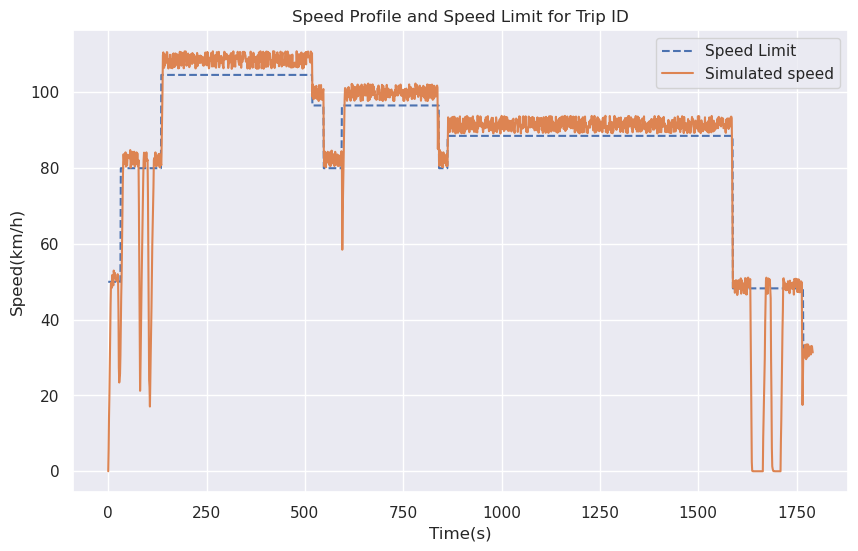

In [49]:
# Plotting
plt.figure(figsize=(10, 6))

# Plot the speed limits
plt.plot(all_speedLimits, label='Speed Limit', linestyle='--')

# Plot the simulated speed
plt.plot(velocityProfile, label='Simulated speed')


# Adding titles and labels
plt.title(f'Speed Profile and Speed Limit for Trip ID')
plt.xlabel('Time(s)')
plt.ylabel('Speed(km/h)')
plt.legend()

plt.show()

In [14]:
def run_fastsim_simulation(all_speeds, veh):
    # Convert speeds from km/h to m/s
    all_speeds_ms = [x / 3.6 for x in all_speeds]
    mps = np.array(all_speeds_ms)
    time_s = np.arange(0, len(mps))
    grade = np.zeros(len(mps))
    road_type = np.zeros(len(mps))

    accel_cyc = {'mps': mps, 'time_s': time_s, 'grade': grade, 'road_type': road_type}

 
    cyc = cycle.Cycle.from_dict(cyc_dict=accel_cyc)

    # Run simulation
    sim_drive = simdrive.SimDrive(cyc, veh)
    sim_drive.sim_drive()
    
    # Assuming sim_drive.fc_kw_in_ach is your list of power values in kW
    power_data = sim_drive.fc_kw_in_ach

    # Convert power data to a NumPy array for easier calculations
    power_array = np.array(power_data)

    # Calculate cumulative energy in kWh
    # Each power data point is assumed to represent one second
    cumulative_energy_kWh = np.cumsum(power_array) / 3600  # converting kWs to kWh
    
    speedProfileInKmh = np.array(sim_drive.mph_ach)*1.609344
    
    
    # Plot results
    fig, ax = plt.subplots(2, 1, figsize=(9, 5))
    ax[0].plot(cyc.time_s, sim_drive.fc_kw_in_ach, label='py')
    ax[0].legend()
    ax[0].set_ylabel('Engine Input\nPower [kW]')

    ax[1].plot(cyc.time_s, sim_drive.mph_ach)
    ax[1].set_xlabel('Cycle Time [s]')
    ax[1].set_ylabel('Speed [MPH]')

    plt.show()

    return power_array, cumulative_energy_kWh, speedProfileInKmh


2024-01-25 15:21:36.156 | simdrive.py:2280 | WARNING: trace miss distance fraction 0.03745 exceeds tolerance of 0.001
2024-01-25 15:21:36.158 | simdrive.py:2298 | WARNING: trace miss speed 10.01978 m/s exceeds tolerance of 1.0 m/s


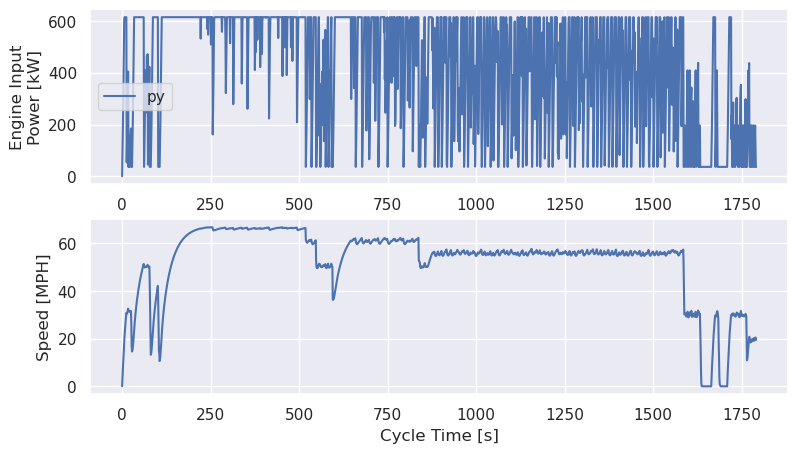

In [51]:
# fastsim part
power_array_simulated, cumulative_energy_kWh_simulated, speed_simulated  = run_fastsim_simulation(velocityProfile, 25)

In [15]:
def plot_simulated_energy(cumulative_energy_kWh_simulated):
# Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(len(cumulative_energy_kWh_simulated)), cumulative_energy_kWh_simulated/40.3*3.7854, label='Cumulative Energy (Simulated Velocity)')
    plt.xlabel('Time (s)')
    plt.ylabel('Cumulative Energy (kWh)')
    plt.title('Cumulative Energy over Time')
    plt.legend()
    plt.grid(True)
    plt.show()


In [16]:
def cumstomize_veh(veh, weight=21000):
    # Load the spreadsheet
    xlsx_file = pd.ExcelFile('data/vehModel/Volvo_EV_Model_KP.xlsx')

    # Load a sheet into a DataFrame by name: Vehicle Model Parameters
    df_parameters = xlsx_file.parse('Vehicle Model Parameters')

    # Select the column for the Murphy Baseline
    murphy_baseline = df_parameters['Murphy Baseline']

    # If you need to access the row by a unique identifier (for example, 'vehOverrideKg'), do the following:
    veh_override_kg = murphy_baseline[df_parameters['Variable'] == 'vehOverrideKg'].values[0]

    attributes = {
        'drag_coef': murphy_baseline[3],
        'frontal_area_m2': murphy_baseline[4],
        'drive_axle_weight_frac': murphy_baseline[7],       
        'veh_override_kg': weight,
        'fs_kwh': murphy_baseline[13],
        'fc_max_kw': murphy_baseline[15],
        'fc_base_kg': murphy_baseline[19],
        'fc_kw_per_kg':  murphy_baseline[20],
        'idle_fc_kw': murphy_baseline[22],
        'ess_kg_per_kwh': murphy_baseline[30],
        'ess_base_kg': murphy_baseline[31],
        'wheel_inertia_kg_m2': murphy_baseline[35],
        'num_wheels': murphy_baseline[36],
        'wheel_rr_coef': murphy_baseline[37],
        'wheel_radius_m': murphy_baseline[38],
        'alt_eff': murphy_baseline[49],
        'chg_eff': murphy_baseline[50],
        'aux_kw': murphy_baseline[51],
        'force_aux_on_fc': True,
        'trans_kg': murphy_baseline[53],
        'trans_eff': murphy_baseline[54],
        'ess_to_fuel_ok_error': murphy_baseline[56], 
        'max_regen': murphy_baseline[57]
    }

    for attr_name, value in attributes.items():
        setattr(veh, attr_name, value)

    return veh


In [64]:
def extract_all_routes_info_from(matched_trip_files):
    # Initialize a list to hold routes_info from all files and trips
    all_routes_info = []

    # Initialize num_trips as 0 before starting the loop
    num_trips = 0
    vehicles_id_list = []
    # Loop over each file to generate a route file
    # Assumption: all trips start at the same time
    for csv_file in matched_trip_files:
        # Read matched trip data for the current file
        matched_trip_data = read_matched_trip_data(csv_file)

        # Process each trip within the current file
        for local_trip_idx, _ in matched_trip_data.iterrows():
            # Global trip index is the current count of num_trips

            edgeList = matched_trip_data.loc[local_trip_idx, "matched_path"]
            nodeList = [edge[0] for edge in edgeList]
            nodeList.append(edgeList[-1][1])
            nodeList = valid_nodeList(nodeList, net)
            edge_route = find_valid_edge_route(nodeList, net)

            # Generate trip_id based on the global trip index
            trip_id = f"t{num_trips}"
            vehicles_id_list.append(trip_id)

            # Prepare route information for the current trip
            route_info = edge_route_to_routes_info(edge_route, trip_id, 0)  # Assuming enter_time is 0 for now
            all_routes_info.append(route_info)

            # Increment num_trips after processing each trip
            num_trips += 1
    return all_routes_info, vehicles_id_list

In [65]:
def fastsim_and_save_to(destination_folder, matched_trip_files, velocity_data, edgeSeq_data):
    # FASTSim and save
    num_trips = 0
    for csv_file in matched_trip_files:
        # Read matched trip data for the current file
        matched_trip_data = read_matched_trip_data(csv_file)
        # Process each trip within the current file
        for local_trip_idx, row in matched_trip_data.iterrows():

            veh_id = f"t{num_trips}" 

            # fastsim part
            # Initialized Vehicle description: https://github.com/NREL/fastsim/blob/fastsim-2/python/fastsim/resources/FASTSim_py_veh_db.csv
            velocityProfile = velocity_data[veh_id]
            if len(velocityProfile):
                velocityProfile = [3.6*x for x in velocityProfile]
                veh = vehicle.Vehicle.from_vehdb(26)
                veh_weight = matched_trip_data.loc[local_trip_idx, 'weight'][0]
                veh = cumstomize_veh(veh, veh_weight)   
                power_array_simulated, cumulative_energy_kWh_simulated, speed_simulated  = run_fastsim_simulation(velocityProfile, veh)

                # Convert the list of edges into a space-separated string if it's not already in this format
                edgeSeq_str = ' '.join(edgeSeq_data[veh_id])
                # Convert each float in the velocity_data list to a string and then join them
                sumoVelocity_str = ' '.join([str(3.6*v) for v in velocity_data[veh_id]])
                fastsimVelocity_str = ' '.join([str(v) for v in speed_simulated])
                power_simulated_str = ' '.join([str(p) for p in power_array_simulated])
                matched_trip_data.loc[local_trip_idx, 'fastsim_velocity'] = fastsimVelocity_str
                matched_trip_data.loc[local_trip_idx, 'fastsim_power'] = power_simulated_str
                matched_trip_data.loc[local_trip_idx, 'sumo_path'] = edgeSeq_str
                matched_trip_data.loc[local_trip_idx, 'sumo_velocity'] = sumoVelocity_str

                # Increment num_trips after processing each trip
                num_trips += 1

                # After processing the current file, save the processed data to the destination folder
                base_file_name = os.path.basename(csv_file)  # Get the base name of the current file
                processed_file_name = base_file_name.replace("_matched", "_processed")
                processed_file_path = os.path.join(destination_folder, processed_file_name)
                matched_trip_data.to_csv(processed_file_path, index=False)
    return

In [ ]:
# Get a list of all files to process
file_pattern = "data/matchedTrips/test/*_matched.csv"
matched_trip_files = glob.glob(file_pattern)

all_routes_info, vehicle_ids = extract_all_routes_info_from(matched_trip_files)

# After collecting routes_info from all files and trips
route_file = "data/incompelete_routes.xml"
save_incomplete_routes_to_xml(all_routes_info, route_file)

complete_route_file = "data/complete_routes.rou.xml"
complete_routes(route_file, net_file, complete_route_file)

# SUMO simulation
begin = 0
end = 14400
step_length = 1
file_name_config = "sumo.sumocfg"
save_sumo_config_to_file(net_file, complete_route_file, begin, end, step_length, file_name_config)
velocity_data, edgeSeq_data = sumo_simulation(file_name_config, vehicle_ids)

# Specify the destination folder for processed files
destination_folder = "data/synthetic/Murphy"
os.makedirs(destination_folder, exist_ok=True)  # Create the destination folder if it doesn't exist
fastsim_and_save_to(destination_folder, matched_trip_files, velocity_data, edgeSeq_data)

In [42]:
# Get a list of all files to process
file_pattern = "data/matchedTrips/test/*_matched.csv"
matched_trip_files = glob.glob(file_pattern)

# Initialize a list to hold routes_info from all files and trips
all_routes_info = []

# Initialize num_trips as 0 before starting the loop
num_trips = 0

# Loop over each file to generate a route file
# Assumption: all trips start at the same time
for csv_file in matched_trip_files:
    print(csv_file)
    # Read matched trip data for the current file
    matched_trip_data = read_matched_trip_data(csv_file)
    
    # Process each trip within the current file
    for local_trip_idx, _ in matched_trip_data.iterrows():
        # Global trip index is the current count of num_trips
        
        edgeList = matched_trip_data.loc[local_trip_idx, "matched_path"]
        nodeList = [edge[0] for edge in edgeList]
        nodeList.append(edgeList[-1][1])
        nodeList = valid_nodeList(nodeList, net)
        edge_route = find_valid_edge_route(nodeList, net)

        # Generate trip_id based on the global trip index
        trip_id = f"t{num_trips}"
               
        # Prepare route information for the current trip
        route_info = edge_route_to_routes_info(edge_route, trip_id, 0)  # Assuming enter_time is 0 for now
        all_routes_info.append(route_info)

        # Increment num_trips after processing each trip
        num_trips += 1

# After collecting routes_info from all files and trips
route_file = "data/incompelete_routes.xml"
save_incomplete_routes_to_xml(all_routes_info, route_file)

complete_route_file = 'data/complete_routes.rou.xml'
complete_routes(route_file, net_file, complete_route_file)

# SUMO simulation
begin = 0
end = 14400
step_length = 1
file_name_config = "sumo.sumocfg"
save_sumo_config_to_file(net_file, complete_route_file, begin, end, step_length, file_name_config)
velocity_data, edgeSeq_data = sumo_simulation(file_name_config, vehicle_ids)

# FASTSim and save

# Specify the destination folder for processed files
destination_folder = "data/synthetic/Murphy"
os.makedirs(destination_folder, exist_ok=True)  # Create the destination folder if it doesn't exist

num_trips = 0
for csv_file in matched_trip_files:
    # Read matched trip data for the current file
    matched_trip_data = read_matched_trip_data(csv_file)
    # Process each trip within the current file
    for local_trip_idx, row in matched_trip_data.iterrows():
            
        veh_id = f"t{num_trips}" 
        
        # fastsim part
        # Initialized Vehicle description: https://github.com/NREL/fastsim/blob/fastsim-2/python/fastsim/resources/FASTSim_py_veh_db.csv
        velocityProfile = velocity_data[veh_id]
        velocityProfile = [3.6*x for x in velocityProfile]
        veh = vehicle.Vehicle.from_vehdb(26)
        veh_weight = matched_trip_data.loc[local_trip_idx, 'weight'][0]
        veh = cumstomize_veh(veh, veh_weight)   
        power_array_simulated, cumulative_energy_kWh_simulated, speed_simulated  = run_fastsim_simulation(velocityProfile, veh)
        
        # Convert the list of edges into a space-separated string if it's not already in this format
        edgeSeq_str = ' '.join(edgeSeq_data[veh_id])
        # Convert each float in the velocity_data list to a string and then join them
        sumoVelocity_str = ' '.join([str(3.6*v) for v in velocity_data[veh_id]])
        fastsimVelocity_str = ' '.join([str(v) for v in speed_simulated])
        power_simulated_str = ' '.join([str(p) for p in power_array_simulated])
        matched_trip_data.loc[local_trip_idx, 'fastsim_velocity'] = fastsimVelocity_str
        matched_trip_data.loc[local_trip_idx, 'fastsim_power'] = power_simulated_str
        matched_trip_data.loc[local_trip_idx, 'sumo_path'] = edgeSeq_str
        matched_trip_data.loc[local_trip_idx, 'sumo_velocity'] = sumoVelocity_str
        
        # Increment num_trips after processing each trip
        num_trips += 1
        
        # After processing the current file, save the processed data to the destination folder
        base_file_name = os.path.basename(csv_file)  # Get the base name of the current file
        processed_file_name = base_file_name.replace("_matched", "_processed")
        processed_file_path = os.path.join(destination_folder, processed_file_name)
        matched_trip_data.to_csv(processed_file_path, index=False)

data/matchedTrips/test/TL5-218_2020W33_matched.csv


KeyboardInterrupt: 

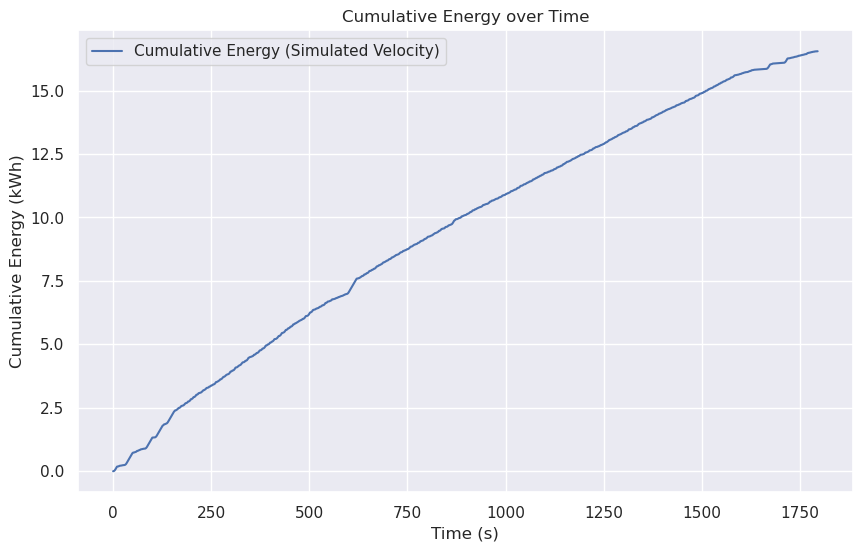

In [19]:
plot_simulated_energy(cumulative_energy_kWh_simulated)

In [59]:
# 1. generate timeslots for simulation 
# 2a. determine the timeslots and the entrance time stamp for each trip, 
# 2b. if the trips anticipated ending time exceed the predifined timeslot, extend the timeslot
# 3. for the trips within the same timeslot, define trips id for them, generate the routes together and do the simulation.
# 4. Save the route, the velocity, the power list for each time stamp. Note that a route may need to be saved as node pairs to connect to origin edges.

In [ ]:
# 1. generate timeslots for simulation 
def read_all_matched_trip_data_for_week(directory, week):
    """
    Read all matched trip data CSV files for a given week from a directory.

    :param directory: The directory containing the CSV files.
    :param week: The week for which to read the data (e.g., '2020W33').
    :return: A DataFrame containing the concatenated data from all matched files.
    """
    
    # Define the file pattern: Any vehicle ID, the specified week, and '_matched.csv'
    file_pattern = f"{directory}/*_{week}_matched.csv"
    
    # Use glob to find all files matching the pattern
    file_paths = glob.glob(file_pattern)
    
    # Read and concatenate all matched trip data files
    all_trip_data = pd.concat([read_matched_trip_data(csv_file) for csv_file in file_paths], ignore_index=True)
    
    return all_trip_data

# group the trip based on their departure date and time slot
# [0-6, 6-9, 9-12, 12-15, 15-19, 19-24 o'clock] 
def get_time_slot(time):
    date_str = time.strftime('%Y-%m-%d')
    if time.hour < 6:
        return f"{date_str}_early_morning"
    elif 6 <= time.hour < 9:
        return f"{date_str}_morning_rush"
    elif 9 <= time.hour < 12:
        return f"{date_str}_late_morning"
    elif 12 <= time.hour < 15:
        return f"{date_str}_afternoon"
    elif 15 <= time.hour < 19:
        return f"{date_str}_evening_rush"
    else:
        return f"{date_str}_night"


In [ ]:
# Read all trips with in the same week
directory = "data/matchedTrips/Murphy"
week = "2020W33"
all_matched_trip_data = read_all_matched_trip_data_for_week(directory, week)